### Task description

We ask you to implement a flow-based model called **Inverse Autoregressive Flow** (https://arxiv.org/abs/1606.04934) to fit a simple 2-dimensional **Gaussian Mixture Model** density. Note that although the paper uses the flow to better approximate the posterior distribution of a VAE, we **do not ask you** to implement the whole VAE in this task. Instead, use the IAF directly for density estimation.

A few notes on the implementation:

* The most important thing in the implementation is a choice of architecture of the autoregressive model. Since we're only dealing with sequences of length 2, using MADE as in the original paper is not necessary. In fact, since the input vector is only two-dimensional, its first component is always transformed by a fixed linear operation. So only the dependency between the second and the first component is to be modeled. This dependency can be modeled by any feedforward network capable of transforming one scalar value into another. We have found a simple dense->relu->dense model (with hidden layers having 16 neurons) to work. Adding batch normalization to this network seems to hurt the performance.

* You might need several IAF steps in order to fit the target density. We have found that including an invertible batch normalization step (implementation included) between the AR steps assists convergence (unlike batch normalization **within** the "autoregressive step" mentioned above). We have found the optimal number of steps to be around 10, where each step uses the same network architecture described above (parameters are not shared between steps). It's important to flip the components of the vector at each IAF step to avoid trivial transformations.

* Note that the IAF formulation implies parallel sampling (i.e. parallel $\mathbf{z} \to \mathbf{x}$ mapping) but autoregressive density estimation (i.e. autoregressive $\mathbf{x} \to \mathbf{z}$ mapping).

* Add visualisations/logging of your choice to demonstrate the learning process.

* We do not constrain you in terms of tools, but we except you to use either PyTorch or Tensorflow as the main deep learning framework. Note that you will have to reimplement some of our starter code in Tensorflow (including the invertible batch norm) should you wish to use Tensorflow.

Please find the starter code below. We provide all the code required to run the training except for the *IAFStep* class which you are to implement. Do not worry about the validation performance; for this task we only care about convergence.

Good luck!

In [ ]:
import math

In [ ]:
import numpy as np

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky

In [ ]:
n_components = 4

means = [
    [3.0, 3.0],
    [3.0, -3.0],
    [-3.0, 3.0],
    [-3.0, -3.0],
]

covs = [
    [0.1, 0.1],
    [0.05, 0.05],
    [0.05, 0.05],
    [0.1, 0.1],
]

weights = [
    0.25,
    0.25,
    0.25,
    0.25
]

In [ ]:
gmm = GaussianMixture(covariance_type="diag", n_components=n_components)

In [ ]:
gmm.weights_ = np.array(weights)
gmm.means_ = np.array(means)
gmm.covariances_ = np.array(covs)
gmm.precisions_cholesky_ = _compute_precision_cholesky(gmm.covariances_, gmm.covariance_type)

In [ ]:
def make_samples(n):
    samples, labels = gmm.sample(n)
    return samples.astype(np.float32)

In [ ]:
def plot_samples(samples, limits=(-10, 10)):
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.2, s=10, c="green")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if limits is not None:
        ax.set_xlim(*limits)
        ax.set_ylim(*limits)
    plt.show()

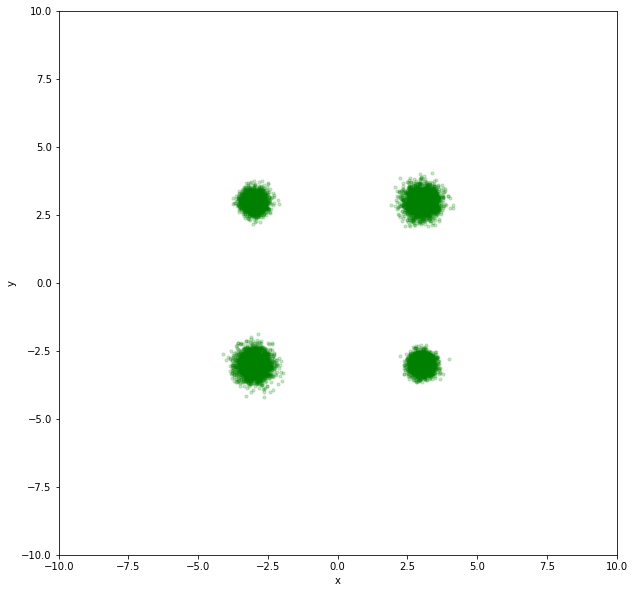

In [ ]:
plot_samples(make_samples(10000))

## 1. IAF / Semi autoregressive,   with ones for the first input, does not converge (still wondering why), scroll further. 



In [ ]:
# IAF Autoregressive
# This implementation does not responde to the requirements because it is autoregressive
# but I was wondering if it works this way and it does not.
# Gradients explode and negative scales.

class IAFStep(torch.nn.Module):

    def __init__(self, flip=False, d_in=2, d_out=4, hidden=2):
        # This should contain the initialization of an "autoregressive" NN.
        super().__init__()
        
        self.d_in = d_in
        self.flip = flip
        
        self.scale_shift_net = nn.Sequential(
              nn.Linear(d_in, hidden),
              nn.Tanh(),
              nn.Linear(hidden, hidden),
              nn.Tanh(),
              nn.Linear(hidden, d_out))

    def _forw(self, scale, shift, z):
      return z*torch.exp(scale)  + shift

    def _rev(self, scale, shift, z):
        return (z - shift)*torch.exp(-scale)

  
    def base(self, z, func):
      if self.flip: z[:,0], z[:,1] = z[:,1], z[:,0]  

      self.log_det = torch.ones(z.size(0))
      Z = torch.ones_like(z)            # One if ideas is to pass vector of ones to learn prior distiributuions for scale & shift for the first dimension
      for i in range(z.shape[1]): 
          scale_shift = self.scale_shift_net(Z.clone()) 
          scale, shift  =  scale_shift.split(self.d_in, dim=1)
          # scale = torch.clamp(scale, -500,500)            # : tried to fix huge scaling numbers
          # print(torch.sum(scale))
          Z[:, i] = func(scale[:,i], shift[:,i], z[:,i])

          self.log_det +=scale[:,i].squeeze(-1)
      return Z

    def forward(self, x):
        # Implement the forward transformation here.
        # It should work in parallel across all "timesteps".

        return self.base(x, self._rev)
        
    def reverse(self, y):
        # Implement the inverse here.
        # Contrary to the forward pass, it works in autoregressive mode.
        return self.base(y, self._forw)
                       
    def log_determinant(self, x=None, y=None):
        # Implement the log determinant of a Jacobian here.
        # It may require making some caching during the inverse pass
        # (see the example in BatchNorm implementation)
        return self.log_det

## 2. IAF / NVP  - Is converging

In [ ]:
# I also understand that this solution is not exactly as was intended 
# but it works with one pass, we flip dimensions each time and we condition one dimention on another

class IAFStep(torch.nn.Module):

    def __init__(self, flip=False, d_in=1, d_out=2, hidden=16):
        # This should contain the initialization of an "autoregressive" NN.
        super().__init__()
        
        self.d_in = d_in
        self.d_out = d_out
        self.flip = flip
        
        
        self.scale_shift_net = nn.Sequential(
              nn.Linear(d_in, hidden),
              nn.ReLU(),
              nn.Linear(hidden, hidden),
              nn.Tanh(),
              nn.Linear(hidden, d_out))

    def _inv(self, y, shift, scale):
      return (y - shift) * torch.exp(-scale)

    def _forw(self, y, shift, scale):
      return y* torch.exp(scale) + shift


    def _base(self, z, func):
        d = z.shape[-1] // 2
        z1, z2 = z[:, :d], z[:, d:] # Splitting dimensions 
        if self.flip: z1, z2= z2, z1  
        shift_scale = self.scale_shift_net(z1) # Modeling mean and scale based on one of the dimensions
        shift, scale = shift_scale[:,0].unsqueeze(1), shift_scale[:,1].unsqueeze(1)
        y = func(z2, shift, scale) # Sampling (y|z1 & z2)
        if self.flip: z1, y = y, z1
        y = torch.cat([z1, y], -1) # Keeping one of the dimesnions as it is with no transfornations
        self.log_det =  scale      # Caching log determinant wich is a sum of scales (if more dimensions)
        return y


    def forward(self, z):
        # Implement the forward transformation here.
        # It should work in parallel across all "timesteps".

        return self._base(z,self._forw)


    def reverse(self, z):
        # Implement the inverse here.
        # Contrary to the forward pass, it works in autoregressive mode.
        
        return self._base(z,self._inv)
                       
    def log_determinant(self, x=None, y=None):
        # Implement the log determinant of a Jacobian here.
        # It may require making some caching during the inverse pass
        # (see the example in BatchNorm implementation)
        return self.log_det

In [ ]:
class BatchNorm(torch.nn.Module):
    # Invertible batch normalization implementation.
    # Just like a usual BatchNorm, but has the reverse method.

    def __init__(self, momentum=0.9, eps=1e-5):
        super().__init__()

        self.log_gamma = torch.nn.Parameter(torch.zeros(2))
        self.beta = torch.nn.Parameter(torch.zeros(2))
        self.momentum = momentum
        self.eps = eps

        self.register_buffer("running_mean", torch.zeros(2))
        self.register_buffer("running_var", torch.ones(2))

    def reverse(self, y):

        if self.training:
            self.batch_mean = y.mean(0)
            self.batch_var = (
                y - self.batch_mean).pow(2).mean(0) + self.eps

            self.running_mean.mul_(self.momentum)
            self.running_var.mul_(self.momentum)

            self.running_mean.add_(self.batch_mean.data *
                                   (1 - self.momentum))
            self.running_var.add_(self.batch_var.data *
                                  (1 - self.momentum))

            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        self.var = var   # cache this for log_determinant()

        x = (y - mean) / var.sqrt()
        x = torch.exp(self.log_gamma) * x + self.beta
        return x
        
    def forward(self, x):
        if self.training:
            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var
            
        self.var = var

        y = (x - self.beta) / torch.exp(self.log_gamma)
        y = y * var.sqrt() + mean
        return y
    
    def log_determinant(self, x=None, y=None):
        if x is not None:
            self(x)
        elif y is not None:
            self.reverse(y)
        
        return -(self.log_gamma - 0.5 * torch.log(self.var)).sum(-1).mean()

In [ ]:
class TransformedDistribution(torch.nn.Module):
    # The class takes a base distribution and a list of invertible transforms.
    # It implements logprob and sampling methods required for training/generation.

    def __init__(self, base_distribution, transforms):
        super().__init__()
        self.base_distribution = base_distribution
        self.transforms = torch.nn.ModuleList(transforms)

    def sample(self, n):
        # sample a batch of size n from the distribution
        self.eval()
        with torch.no_grad():
            z = self.base_distribution.sample(n)
            for transform in self.transforms:
                z = transform(z)
            return z
    
    def sample_hierarcical(self, n):
        # works in the same way as sample(),
        # but returns z from all transformation steps
        self.eval()
        with torch.no_grad():
            z = self.base_distribution.sample(n)
            zs = [z]
            for transform in self.transforms:
                z = transform(z)
                zs.append(z)
            return zs

    def logprob(self, x):
        # compute the log probability of given datapoints
        # by iteratively transforming x to z and using
        # the change of variables rule 
        
        self.train()

        y = x

        log_det = torch.zeros(x.size(0))

        for transform in reversed(self.transforms):
            x = transform.reverse(y)
            log_det = log_det - transform.log_determinant()
            y = x

        loss = torch.mean(log_det)  + self.base_distribution.logprob(y)

        return loss


class StandardNormalDistribution(torch.nn.Module):

    def __init__(self, sample_shape):
        super().__init__()

        self.sample_shape = sample_shape

    def sample(self, n):
        with torch.no_grad():
            z = torch.zeros(n, *self.sample_shape).normal_()
            return z

    def logprob(self, x):

        n = x.size(0)
        return (-(x ** 2) / 2 - math.log(math.sqrt(2 * math.pi))).sum() / n

In [ ]:
layers = 10    # feel free to change this value

In [ ]:
transforms = []
for k in range(layers):
    transforms.append(IAFStep(flip=bool(k%2))) # keep track of flips   # requires an implemented IAFStep class (see above)
    transforms.append(BatchNorm())


In [ ]:
base = StandardNormalDistribution(sample_shape=(2,))
transformed_distribution = TransformedDistribution(base, transforms)

optimizer = torch.optim.Adam(
    transformed_distribution.parameters(), lr=1e-3, weight_decay=0)  # feel free to play with the parameters
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)

In [ ]:
def train(distribution, optimizer, scheduler, steps, batch_size, log_interval=50):

    for step in range(steps):
        
        distribution.train()
        
        data = torch.from_numpy(make_samples(batch_size))

        optimizer.zero_grad()
        logprob = distribution.logprob(data)
        loss = -logprob
        loss.backward()
        #nn.utils.clip_grad_norm_(distribution.parameters(), -1000,1000)
        optimizer.step()
        scheduler.step()

        if step % log_interval == 0:
            print("Step:", step, "loss:", loss.item())
            plot_samples(distribution.sample(10000).data.numpy())

Step: 0 loss: 5.323430061340332


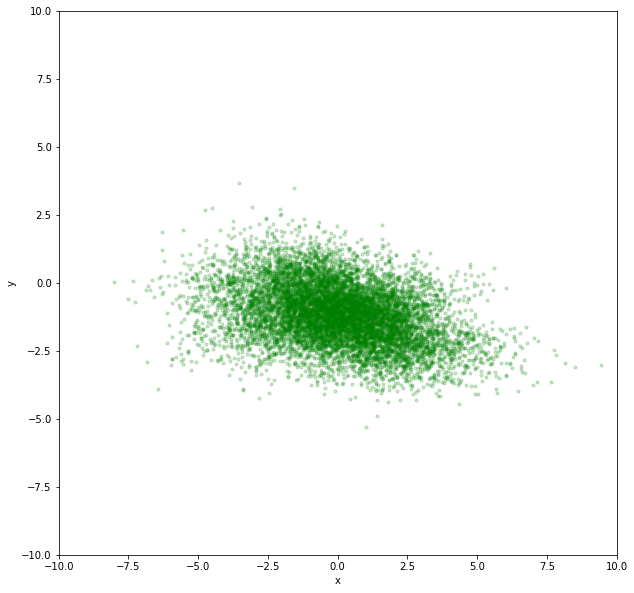

Step: 200 loss: 2.64412784576416


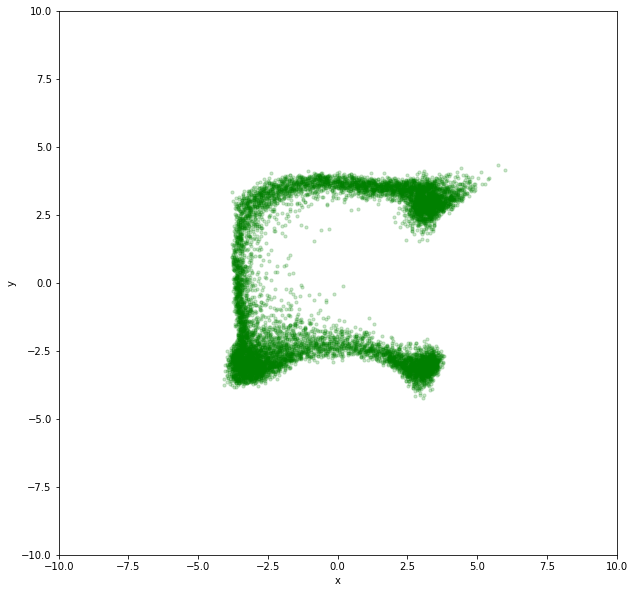

Step: 400 loss: 2.2435336112976074


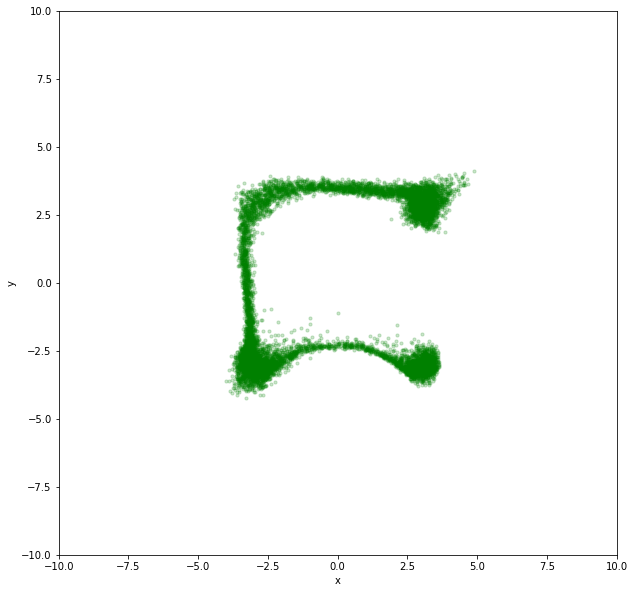

Step: 600 loss: 2.3914687633514404


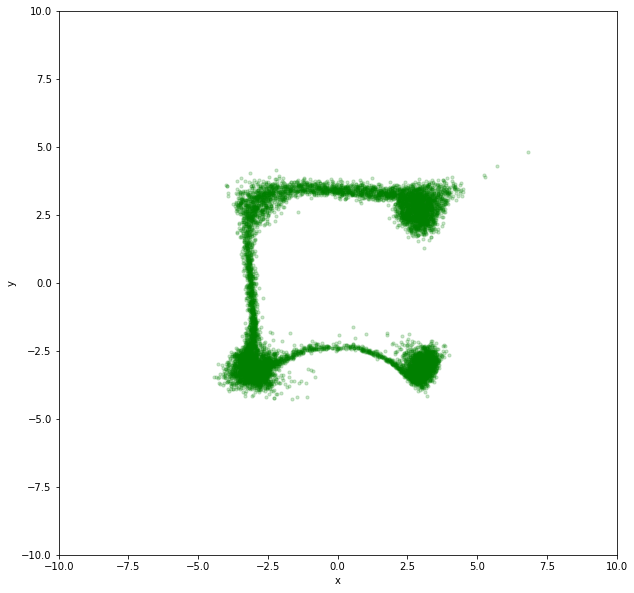

Step: 800 loss: 2.0586249828338623


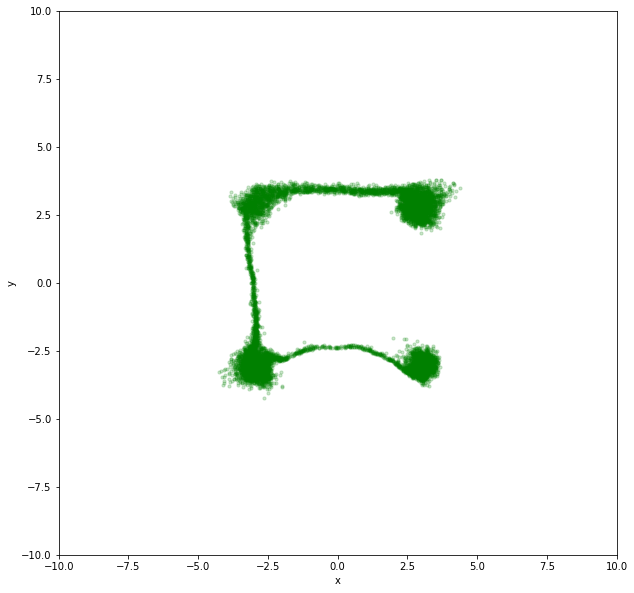

Step: 1000 loss: 2.137472629547119


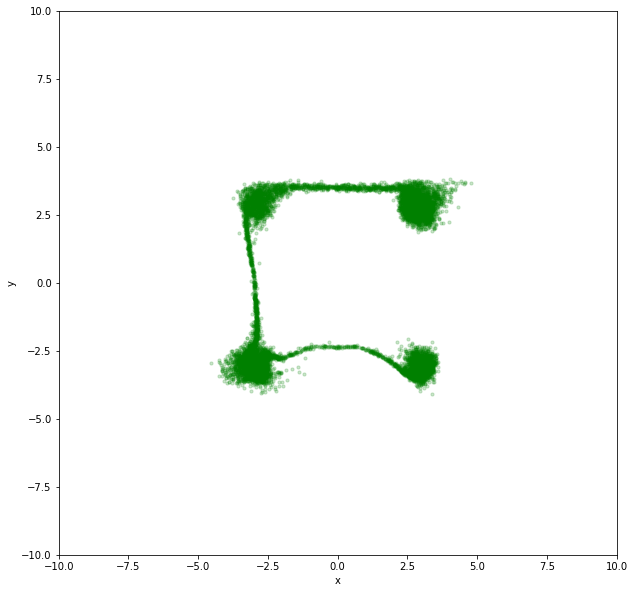

Step: 1200 loss: 2.0766210556030273


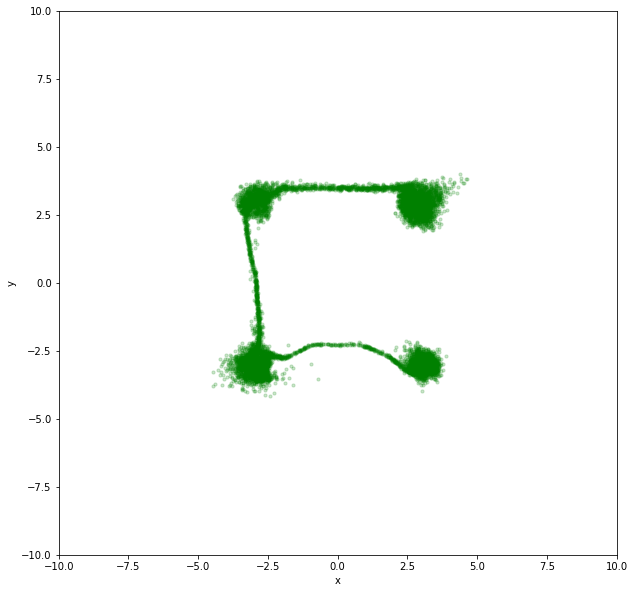

Step: 1400 loss: 2.0216472148895264


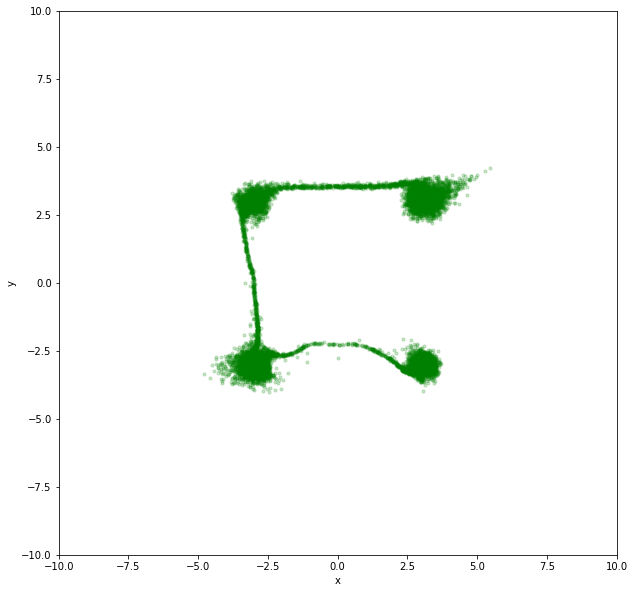

Step: 1600 loss: 1.9872113466262817


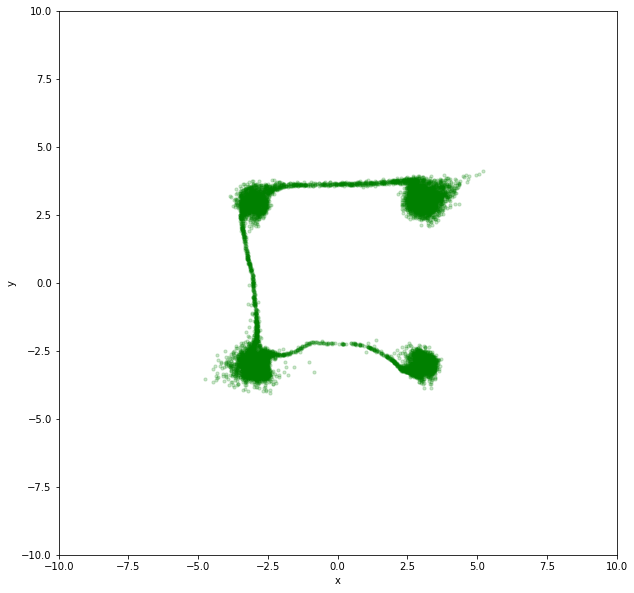

Step: 1800 loss: 1.9283443689346313


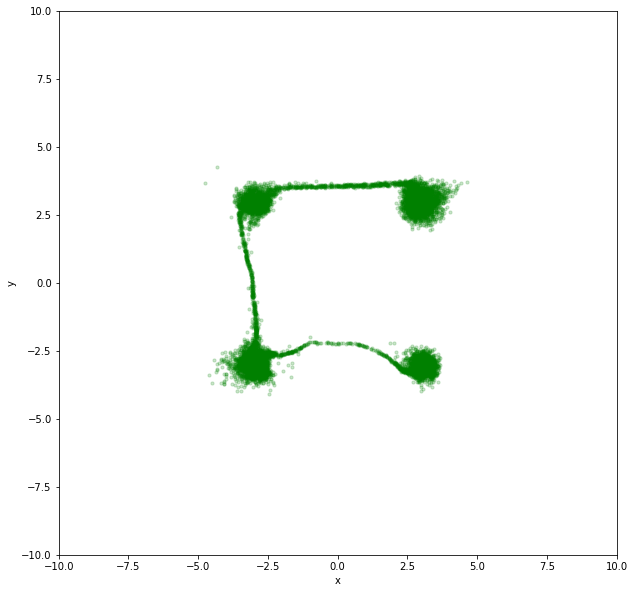

In [ ]:
train(
    transformed_distribution,
    optimizer,
    scheduler,
    steps=2000,     # feel free to tweek 
    batch_size=1024,   # any of these parameters
    log_interval=200  # or add/remove them
)